In [2]:
import arviz as az
import pandas as pd
import json
import os

import numpy as np
import diffrax
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import jax
import sys
from scipy.stats import mode

jax.config.update("jax_enable_x64", True)

%matplotlib inline
plt.style.use('custom')

# custom plotting helper funcs
sys.path.insert(0, '../')
from plotting_helper_funcs import *
from utils import *

rng = np.random.default_rng(seed=1234)

%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Now load in all of the posterior idata and the posterior predictive samples...

In [6]:
savedir = '../../../results/MAPK/param_est/HF96_synthetic_data/'

model_info = json.load(open('../param_est/model_info.json'))
model_names = list(model_info.keys())
model_names.remove('hatakeyama_2003')
display_names = [model_info[model]['display_name'] for model in model_names]

idata = {}
posterior_pred_samples = {}
posterior_samples = {}
ss = {}
log_marginal_likes = []

for model in model_names:
    if model != 'hatakeyama_2003':
        idata[model], ss[model] = load_smc_samples_to_idata(savedir+model+'/'+model+'_smc_samples.json')
        posterior_pred_samples[model] = np.load(savedir+model+'/'+model+'_posterior_predictive_samples.npy')
        posterior_samples[model] = np.load(savedir+model+'/dose_response_predict.npy')
    


# Log marginal likelihoods
log_marginal_likes.append(np.mean([chain[-1] for chain in ss['kholodenko_2000']['log_marginal_likelihood'][0]]))
log_marginal_likes.append(np.mean([chain[-1] for chain in ss['levchenko_2000']['log_marginal_likelihood']]))
# log_marginal_likes.append( np.mean([chain[-1] for chain in ss['hatakeyama_2003']['log_marginal_likelihood']]))
log_marginal_likes.append(np.mean([chain[-1] for chain in ss['hornberg_2005']['log_marginal_likelihood'][0]]))
log_marginal_likes.append(np.mean([chain[-1] for chain in ss['birtwistle_2007']['log_marginal_likelihood'][0]]))
log_marginal_likes.append(np.mean([chain[-1] for chain in ss['orton_2009']['log_marginal_likelihood'][0]]))
log_marginal_likes.append( np.mean([chain[-1] for chain in ss['vonKriegsheim_2009']['log_marginal_likelihood'][0]])) 
log_marginal_likes.append(np.mean([chain[-1] for chain in ss['shin_2014']['log_marginal_likelihood'][0]]))
log_marginal_likes.append(np.mean([chain[-1] for chain in ss['ryu_2015']['log_marginal_likelihood']]))
log_marginal_likes.append(np.mean([chain[-1] for chain in ss['kochanczyk_2017']['log_marginal_likelihood']]))

log_marginal_likes = np.array(log_marginal_likes)

posterior_pred_samples_mod = posterior_pred_samples.copy()
# Birtwistle 2007 only has 400 posterior predictive samples, so we duplicate and randomly permute them 
# to get 4000
B_2007_posts = [posterior_pred_samples_mod['birtwistle_2007'] for _ in range(10)]
B_2007_post = np.vstack(B_2007_posts)
posterior_pred_samples_mod['birtwistle_2007'] = B_2007_post[rng.permutation(np.arange(4000))]

# vonKreigsheim 2009 only has 400 posterior predictive samples, so we duplicate and randomly permute them to get 4000
vK_2009_posts = [posterior_pred_samples_mod['vonKriegsheim_2009'] for _ in range(10)]
vK_2009_post = np.vstack(vK_2009_posts)
posterior_pred_samples_mod['vonKriegsheim_2009'] = vK_2009_post[rng.permutation(np.arange(4000))]

# Hornberg 2005 only has 400 posterior predictive samples, so we duplicate and randomly permute them to get 4000
H_2005_posts = [posterior_pred_samples_mod['hornberg_2005'] for _ in range(10)]
H_2005_post = np.vstack(H_2005_posts)
posterior_pred_samples_mod['hornberg_2005'] = H_2005_post[rng.permutation(np.arange(4000))]

# shin has 16000 so downsample to 4000
idxs = rng.choice(np.arange(16000), size=4000, replace=False)
posterior_pred_samples['shin_2014'] = posterior_pred_samples['shin_2014'][idxs]
posterior_pred_samples_mod['shin_2014'] = posterior_pred_samples_mod['shin_2014'][idxs]

posterior_pred_samples = posterior_pred_samples_mod

# get data training data
inputs, data = load_data('../../../results/MAPK/HF_96_synthetic_data.csv')

# set up a color palette
# this is the ColorBrewer purple-green with 11 colors + three greys https://colorbrewer2.org/#type=diverging&scheme=PRGn&n=11
colors = ['#40004b','#762a83','#9970ab','#c2a5cf','#e7d4e8','#f7f7f7','#d9f0d3','#a6dba0','#5aae61','#1b7837','#00441b','#363737','#929591','#d8dcd6']
# this one gets to 10 colors by removing the darkest purple
colors = ['#40004b','#762a83','#9970ab','#c2a5cf','#e7d4e8','#f7f7f7','#d9f0d3','#a6dba0','#5aae61','#1b7837','#363737','#929591','#d8dcd6']
orange = '#de8f05'

Now run arviz model comparison get eldpd_loo for each model and save to a dict

In [7]:
compare_data_waic_pbma = az.compare(idata, ic='waic', method='BB-pseudo-BMA', seed=rng)
compare_data_loo_pbma = az.compare(idata, ic='loo', method='BB-pseudo-BMA', seed=rng)
compare_data_waic_stack = az.compare(idata, ic='waic', method='stacking', seed=rng)
compare_data_loo_stack = az.compare(idata, ic='loo', method='stacking', seed=rng)

/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/natetest/miniforge3/envs/pymc/lib/python3.11/sit

[-12.231074641294345, 11.03212812425802, 0.8272672107413079, 8.295758143386331, -13.832770979974137, 8.117581946398516, 9.0622216218709, 8.565257744093211, 11.668786002892212]


/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_26044/1706764441.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names, rotation=90, fontsize=10.0)
/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_26044/1706764441.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names, rotation=90, fontsize=10.0)


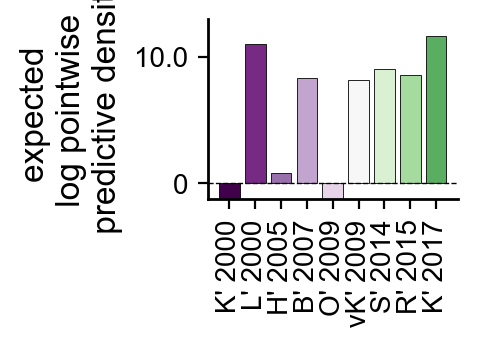

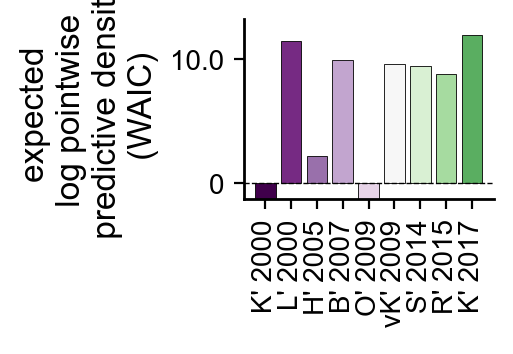

In [25]:
# make a plot of elpd_loo, and elpd_waic
dat = [compare_data_loo_stack.loc[model]['elpd_loo'] for model in model_names]
print(dat)
fig, ax = get_sized_fig_ax(1.25, 0.9)
bar = ax.bar(model_names, dat, edgecolor='k')
ax.set_ylabel('expected \n log pointwise \n predictive density', fontsize=12)
ax.set_xticklabels(display_names, rotation=90, fontsize=10.0)
for i, br in enumerate(bar):
    br.set_facecolor(colors[i])
xlim = ax.get_xlim()
ax.plot(xlim, [0,0], '--k', linewidth=0.5)
ax.set_xlim(xlim)
ylim = ax.get_ylim()
ax.set_ylim(-0.1*ylim[1], ylim[1])
ax.set_yticks([0, 10.0])
ax.set_yticklabels([0, 10.0], fontsize=10.0)
fig.savefig('../../../results/MAPK/mmi/HF96_elpd_loo.pdf', transparent=True)

# waic
dat = [compare_data_waic_stack.loc[model]['elpd_waic'] for model in model_names]
fig, ax = get_sized_fig_ax(1.25, 0.9)
bar = ax.bar(model_names, dat, edgecolor='k')
for i, br in enumerate(bar):
    br.set_facecolor(colors[i])

ax.set_ylabel('expected \n log pointwise \n predictive density \n (WAIC)', fontsize=12)
ax.set_xticklabels(display_names, rotation=90, fontsize=10.0)
xlim = ax.get_xlim()
ax.plot(xlim, [0,0], '--k', linewidth=0.5)
ax.set_xlim(xlim)

ylim = ax.get_ylim()
ax.set_ylim(-0.1*ylim[1], ylim[1])
ax.set_yticks([0, 10.0])
ax.set_yticklabels([0, 10.0], fontsize=10.0)
fig.savefig('../../../results/MAPK/mmi/HF96_elpd_waic.pdf', transparent=True)

## Quick test to play around with different ways to calculate pBMA weights from ELPD estimates

In [9]:
# construct loo_i matrix
loo_i = np.zeros((len(model_names), len(data)))
for i, model in enumerate(list(compare_data_loo_pbma['rank'].keys())):
    loo_i[i, :] = az.loo(idata[model], pointwise=True).loo_i.values.T

/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/natetest/miniforge3/envs/pymc

In [10]:
def weight_elpd_diff(elpd_difs):
    """ Compute weights using elpd differences as in 
    https://bayesiancomputationbook.com/markdown/chp_02.html#model-averaging"""

    return np.exp(-1*elpd_difs)/np.sum(np.exp(-1*elpd_difs))

def weight_elpd(elpd):
    """ Compute weights using elpd as in Yao et al. 2018 Stacking paper"""
    return np.exp(elpd)/np.sum(np.exp(elpd))

def weight_log_exponential(elpd, se):
    """ Compute weights using elpd and se as in Yao et al. 2018 Stacking paper.
    This is referred to as the log-exponential method."""
    return np.exp(elpd - se/2)/np.sum(np.exp(elpd - se/2))

def weight_elpd_BB(elpd_loo_i_matrix, bootstrap_size=10):
    """ Compute weights using elpd and the Bayesian Bootstrap as in Yao et al. 2018 Stacking paper. """
    samples = np.zeros((elpd_loo_i_matrix.shape[0], bootstrap_size))
    n = elpd_loo_i_matrix.shape[1]
    for b in range(bootstrap_size):
        alpha = rng.dirichlet(np.ones(n), size=1)
        for k,loo_i in enumerate(elpd_loo_i_matrix):
            samples[k,b] = np.dot(alpha,loo_i)[0]
    
    # exponentiate and normalize samples to sum to 1
    samples = np.exp(n*samples) # exponentiate
    samples = samples/np.sum(samples, axis=0) # normalize

    # compute mean over samples
    weights = np.mean(samples, axis=1)
    return weights, samples

weights_elpd_diff = weight_elpd_diff(compare_data_loo_pbma['elpd_diff'].values)
weights_elpd = weight_elpd(compare_data_loo_pbma['elpd_loo'].values)
weights_log_exponential = weight_log_exponential(compare_data_loo_pbma['elpd_loo'].values, compare_data_loo_pbma['se'].values)
weights_elpd_BB, samples = weight_elpd_BB(loo_i, bootstrap_size=1000)

print('weights_elpd_diff:', weights_elpd)
print('weights elpd:', weights_elpd)
print('weights_log_exponential:', weights_log_exponential)
print('weights_elpd_BB:', weights_elpd_BB)
print('weights_arviz:', compare_data_loo_pbma['weight'].values)

weights_elpd_diff: [5.84545399e-01 3.09258214e-01 4.31322108e-02 2.62405570e-02
 2.00415294e-02 1.67706510e-02 1.14394846e-05 2.43916203e-11
 4.91623652e-12]
weights elpd: [5.84545399e-01 3.09258214e-01 4.31322108e-02 2.62405570e-02
 2.00415294e-02 1.67706510e-02 1.14394846e-05 2.43916203e-11
 4.91623652e-12]
weights_log_exponential: [5.64338856e-03 9.14249826e-01 5.24128159e-03 1.84083823e-03
 5.18764775e-02 2.11277653e-02 2.04230813e-05 8.54914168e-11
 5.55898955e-12]
weights_elpd_BB: [5.18742370e-01 2.75581890e-01 6.87550151e-02 4.05185903e-02
 5.42159069e-02 3.87254224e-02 2.78846320e-03 7.86941361e-07
 6.71555418e-04]
weights_arviz: [5.17152868e-01 2.75432248e-01 6.99789936e-02 4.06598168e-02
 5.48560974e-02 3.85907948e-02 3.00324129e-03 1.80125914e-06
 3.24138573e-04]


Bayesian model averaging - plot bar plot of model probabilities

[-10.55782407   5.02413276  -7.6129868    5.33193453 -28.36095985
   4.75012892   7.68601559   6.40375142   7.58190537]


/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_26044/2528862212.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names, rotation=90, fontsize=10.0)


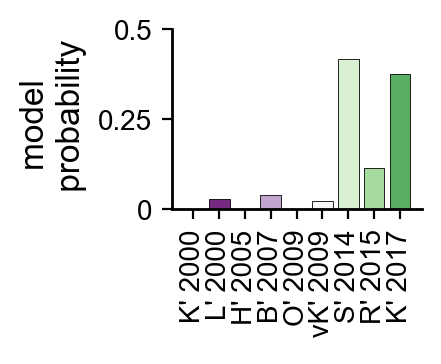

In [11]:
n_models = len(log_marginal_likes)
prior_prob = 1/n_models

normalizing_constant = np.sum(prior_prob*np.exp(log_marginal_likes))
model_probs = prior_prob*np.exp(log_marginal_likes)/normalizing_constant
print(log_marginal_likes)
fig, ax = get_sized_fig_ax(1.25, 0.9)
bar = ax.bar(model_names, model_probs, edgecolor='k')
for i, br in enumerate(bar):
    br.set_facecolor(colors[i])

ax.set_ylabel('model \n probability', fontsize=12)
xlim = ax.get_xlim()
ax.plot(xlim, [0,0], '--k', linewidth=0.5)
ax.set_xlim(xlim)
ax.set_ylim([0, 0.5])
ax.set_yticks([0, 0.25, 0.5])
ax.set_yticklabels([0, 0.25, 0.5], fontsize=10.0)
ax.set_xticklabels(display_names, rotation=90, fontsize=10.0)
# ax.set_ylim([0, 1.0])
fig.savefig('../../../results/MAPK/mmi/HF96_model_prob.pdf', transparent=True)

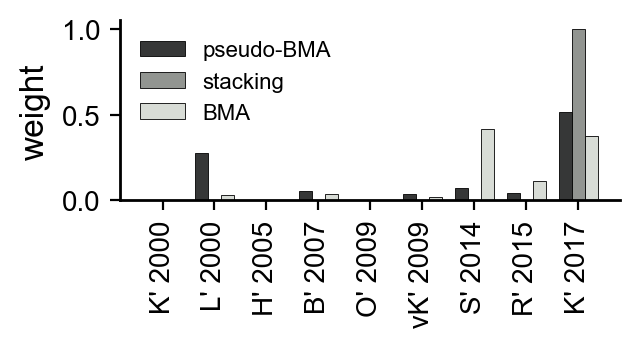

In [12]:
x = np.arange(n_models)  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

stack = [compare_data_loo_stack.loc[model]['weight'] for model in model_names]
pBMA = [compare_data_loo_pbma.loc[model]['weight'] for model in model_names]

# 
fig, ax = get_sized_fig_ax(2.5, 0.9)
for dat, name, col in zip([pBMA, stack, model_probs], ['pseudo-BMA','stacking','BMA',], [colors[-3], colors[-2], colors[-1]]):
    offset = width * multiplier
    bar = ax.bar(x + offset, dat, width, label=name, color=col, edgecolor='k')
    # ax.bar_label(bar, padding=3)
    multiplier += 1

ax.set_ylabel('model weight', fontsize=12)
ax.set_xticks(x + width, display_names)
ax.set_yticks([0.0, 0.5, 1.0])
ax.set_yticklabels(['0.0', '0.5', '1.0'], fontsize=10.0)
ax.legend(loc='upper left', fontsize=8.0)

ax.set_ylabel(r'weight', fontsize=12)
ax.set_xticklabels(display_names, rotation=90, fontsize=10.0)
# ax.set_ylim([0, 1.0])
fig.savefig('../../../results/MAPK/mmi/HF96_model_weights.pdf', transparent=True)

Generate predictive samples from the averaged predictive density

In [13]:
# first wiith posterior predictive samples
loo_pbma_combined = np.zeros_like(posterior_pred_samples['kholodenko_2000'])
loo_stack_combined = np.zeros_like(posterior_pred_samples['kholodenko_2000'])
loo_bma_combined = np.zeros_like(posterior_pred_samples['kholodenko_2000'])
for i, name in enumerate(model_names):
    loo_pbma_combined += compare_data_loo_pbma.loc[name]['weight']*posterior_pred_samples[name]
    loo_stack_combined += compare_data_loo_stack.loc[name]['weight']*posterior_pred_samples[name]
    loo_bma_combined += model_probs[i]*posterior_pred_samples[name]

# then with posterior samples
loo_pbma_combined_post = np.zeros_like(posterior_samples['kholodenko_2000'])
loo_stack_combined_post = np.zeros_like(posterior_samples['kholodenko_2000'])
loo_bma_combined_post = np.zeros_like(posterior_samples['kholodenko_2000'])
for i, name in enumerate(model_names):
    loo_pbma_combined_post += compare_data_loo_pbma.loc[name]['weight']*posterior_samples[name]
    loo_stack_combined_post += compare_data_loo_stack.loc[name]['weight']*posterior_samples[name]
    loo_bma_combined_post += model_probs[i]*posterior_samples[name]

In [14]:
def plot_stimulus_response_curve(samples, data, inputs, box_color='k', data_color='r', input_name='EGF stimulus', 
                                 output_name='% maximal ERK activity',
                                 data_std=0.1, width=6.0, height=3.0, scatter_marker_size=50, data_marker_size=7):
    dat = {}
    for i,input in enumerate(inputs):
        dat[input] = samples[:,i]

    data_df = pd.DataFrame(dat)

    fig, ax = get_sized_fig_ax(width, height)
    sns.boxplot(data=data_df, color=box_color, ax=ax, whis=(2.5, 97.5), fill=True, 
                native_scale=True, log_scale=(10, 0), fliersize=0, width=0.65)
    ax.set_xlabel(input_name)
    ax.set_ylabel(output_name)

    errors = data_std*np.squeeze(np.ones_like(data))
    ax.scatter(inputs, data, color=data_color, marker='x', s=scatter_marker_size, zorder=10, label='synthetic data')
    ax.errorbar(inputs, np.squeeze(data), yerr=errors, color=data_color, fmt='x', markersize=data_marker_size, zorder=10)

    return fig, ax

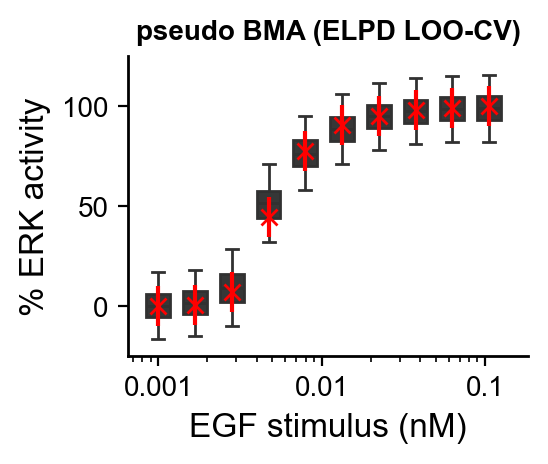

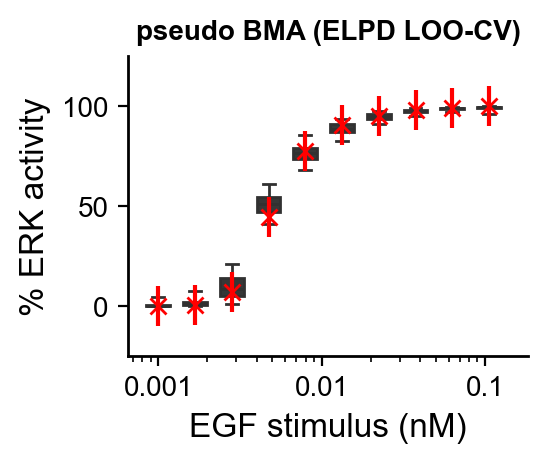

In [15]:
# with posterior pred samples
fig, ax = plot_stimulus_response_curve(loo_pbma_combined, data, inputs, input_name='EGF stimulus (nM)', 
                                 output_name='% ERK activity', box_color=colors[-3], data_color='red',
                                 data_std=0.1, width=2., height=1.5, data_marker_size=6.0, scatter_marker_size=0)
ax.set_title('pseudo BMA (ELPD LOO-CV)', fontsize=10)
leg = ax.legend(ncols=6, fontsize=10, bbox_to_anchor=(10, 10))
export_legend(leg, '../../../results/MAPK/mmi/HF96_pbma_avg_legend.pdf')
leg.remove()

ax.set_ylim([-0.25, 1.25])
ax.set_yticks([0, 0.5, 1.0])
ax.set_yticklabels(['0', '50', '100'], fontsize=10.0)
ax.set_xticks([0.001, 0.01, 0.1])
ax.set_xticklabels([0.001, 0.01, 0.1], fontsize=10.0)
ax.set_xlabel(ax.get_xlabel(), fontsize=12.0)
ax.set_ylabel(ax.get_ylabel(), fontsize=12.0)

fig.savefig('../../../results/MAPK/mmi/HF96_pbma_avg.pdf', transparent=True)

############################################################################################################
# with posterior samples
fig, ax = plot_stimulus_response_curve(loo_pbma_combined_post, data, inputs, input_name='EGF stimulus (nM)', 
                                 output_name='% ERK activity', box_color=colors[-3], data_color='red',
                                 data_std=0.1, width=2., height=1.5, data_marker_size=6.0, scatter_marker_size=0)
ax.set_title('pseudo BMA (ELPD LOO-CV)', fontsize=10)
leg = ax.legend(ncols=6, fontsize=10, bbox_to_anchor=(10, 10))
export_legend(leg, '../../../results/MAPK/mmi/HF96_pbma_avg_legend.pdf')
leg.remove()

ax.set_ylim([-0.25, 1.25])
ax.set_yticks([0, 0.5, 1.0])
ax.set_yticklabels(['0', '50', '100'], fontsize=10.0)
ax.set_xticks([0.001, 0.01, 0.1])
ax.set_xticklabels([0.001, 0.01, 0.1], fontsize=10.0)
ax.set_xlabel(ax.get_xlabel(), fontsize=12.0)
ax.set_ylabel(ax.get_ylabel(), fontsize=12.0)

fig.savefig('../../../results/MAPK/mmi/HF96_pbma_avg_post_samples.pdf', transparent=True)

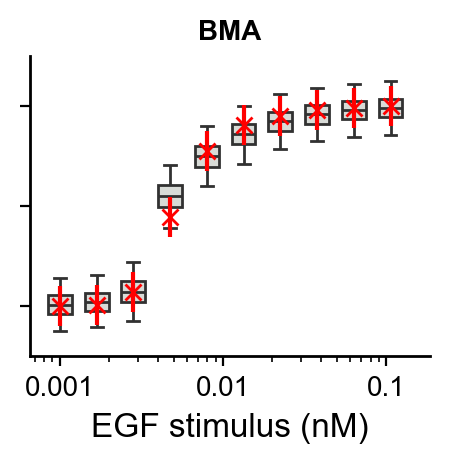

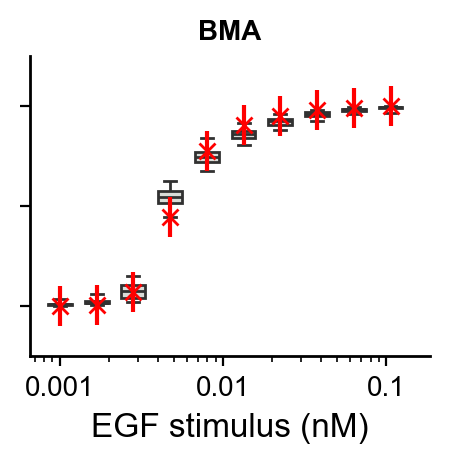

In [16]:
# post pred samples
fig, ax = plot_stimulus_response_curve(loo_bma_combined, data, inputs, input_name='EGF stimulus (nM)', 
                                 output_name='% maximal ERK activity', box_color=colors[-1], data_color='red',
                                 data_std=0.1, width=2., height=1.5, data_marker_size=6.0, scatter_marker_size=0)
ax.set_title('BMA', fontsize=10)
leg = ax.legend()

eg = ax.legend(ncols=6, fontsize=10, bbox_to_anchor=(10, 10))
export_legend(leg, '../../../results/MAPK/mmi/HF96_bma_avg_legend.pdf')
leg.remove()

ax.set_ylim([-0.25, 1.25])
ax.set_yticks([0, 0.5, 1.0])
# ax.set_yticklabels(['0', '50', '100'], fontsize=8)
ax.set_yticklabels([], fontsize=10.0)
ax.set_xticks([0.001, 0.01, 0.1])
ax.set_xticklabels([0.001, 0.01, 0.1], fontsize=10.0)
ax.set_xlabel(ax.get_xlabel(), fontsize=12.0)
# ax.set_ylabel(ax.get_ylabel(), fontsize=10.0)
ax.set_ylabel('')

fig.savefig('../../../results/MAPK/mmi/HF96_bma_avg.pdf', transparent=True)

############################################################################################################
# post samples
fig, ax = plot_stimulus_response_curve(loo_bma_combined_post, data, inputs, input_name='EGF stimulus (nM)', 
                                 output_name='% maximal ERK activity', box_color=colors[-1], data_color='red',
                                 data_std=0.1, width=2., height=1.5, data_marker_size=6.0, scatter_marker_size=0)
ax.set_title('BMA', fontsize=10)
leg = ax.legend()

eg = ax.legend(ncols=6, fontsize=10, bbox_to_anchor=(10, 10))
export_legend(leg, '../../../results/MAPK/mmi/HF96_bma_avg_legend.pdf')
leg.remove()

ax.set_ylim([-0.25, 1.25])
ax.set_yticks([0, 0.5, 1.0])
# ax.set_yticklabels(['0', '50', '100'], fontsize=8)
ax.set_yticklabels([], fontsize=10.0)
ax.set_xticks([0.001, 0.01, 0.1])
ax.set_xticklabels([0.001, 0.01, 0.1], fontsize=10.0)
ax.set_xlabel(ax.get_xlabel(), fontsize=12.0)
# ax.set_ylabel(ax.get_ylabel(), fontsize=10.0)
ax.set_ylabel('')


fig.savefig('../../../results/MAPK/mmi/HF96_bma_avg_post_samples.pdf', transparent=True)

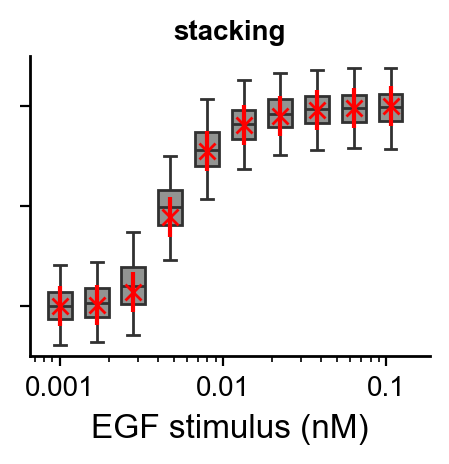

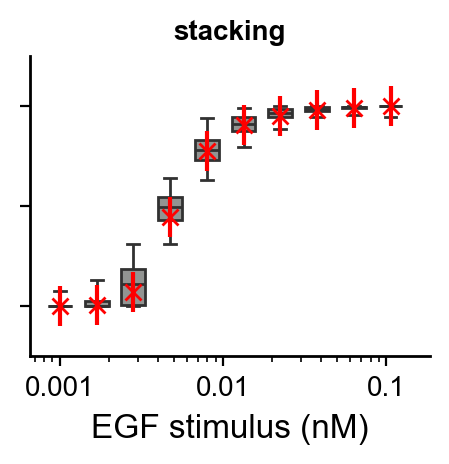

In [17]:
# post pred
fig, ax = plot_stimulus_response_curve(loo_stack_combined, data, inputs, input_name='EGF stimulus (nM)', 
                                 output_name='% maximal ERK activity', box_color=colors[-2], data_color='red',
                                 data_std=0.1, width=2., height=1.5, data_marker_size=6.0, scatter_marker_size=0)

ax.set_title('stacking', fontsize=10)
leg = ax.legend()

eg = ax.legend(ncols=6, fontsize=10, bbox_to_anchor=(10, 10))
export_legend(leg, '../../../results/MAPK/mmi/HF96_stack_avg_legend.pdf')
leg.remove()

ax.set_ylim([-0.25, 1.25])
ax.set_yticks([0, 0.5, 1.0])
# ax.set_yticklabels(['0', '50', '100'], fontsize=8)
ax.set_yticklabels([], fontsize=10.0)
ax.set_xticks([0.001, 0.01, 0.1])
ax.set_xticklabels([0.001, 0.01, 0.1], fontsize=10.0)
ax.set_xlabel(ax.get_xlabel(), fontsize=12.0)
# ax.set_ylabel(ax.get_ylabel(), fontsize=10.0)
ax.set_ylabel('')

fig.savefig('../../../results/MAPK/mmi/HF96_stack_avg.pdf', transparent=True)

############################################################################################################
# post samples
fig, ax = plot_stimulus_response_curve(loo_stack_combined_post, data, inputs, input_name='EGF stimulus (nM)', 
                                 output_name='% maximal ERK activity', box_color=colors[-2], data_color='red',
                                 data_std=0.1, width=2., height=1.5, data_marker_size=6.0, scatter_marker_size=0)

ax.set_title('stacking', fontsize=10)
leg = ax.legend()

eg = ax.legend(ncols=6, fontsize=10, bbox_to_anchor=(10, 10))
export_legend(leg, '../../../results/MAPK/mmi/HF96_stack_avg_legend.pdf')
leg.remove()

ax.set_ylim([-0.25, 1.25])
ax.set_yticks([0, 0.5, 1.0])
# ax.set_yticklabels(['0', '50', '100'], fontsize=8)
ax.set_yticklabels([], fontsize=10.0)
ax.set_xticks([0.001, 0.01, 0.1])
ax.set_xticklabels([0.001, 0.01, 0.1], fontsize=10.0)
ax.set_xlabel(ax.get_xlabel(), fontsize=12.0)
# ax.set_ylabel(ax.get_ylabel(), fontsize=10.0)
ax.set_ylabel('')


fig.savefig('../../../results/MAPK/mmi/HF96_stack_avg_post_samples.pdf', transparent=True)


Now compute RMSE for each model. Will do this for each model averaged predictive sample then make a bar plot with error bars

/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_26044/3198142019.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names + ['pseudo-BMA', 'stacking', 'BMA'], rotation=90, fontsize=10.0)
/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_26044/3198142019.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names + ['pseudo-BMA', 'stacking', 'BMA'], rotation=90, fontsize=10.0)


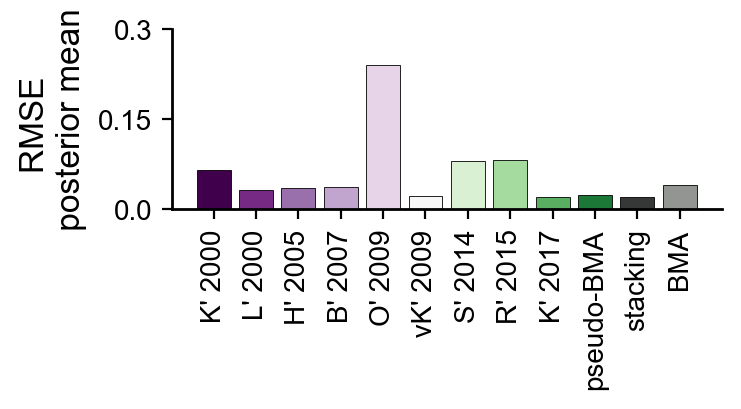

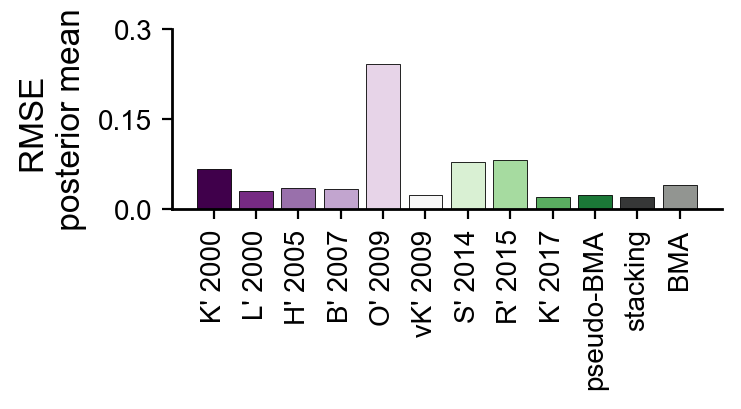

In [18]:
# post pred samples
RMSE_samples_pred = []
RMSE_stds_pred = []
for i, name in enumerate(model_names):
    RMSE_samples_pred.append(np.sqrt(np.nanmean((np.nanmean(posterior_pred_samples[name], axis=0) - data.T)**2)))
    RMSE_stds_pred.append(np.sqrt(np.nanmean((np.nanstd(posterior_pred_samples[name], axis=0) - data.T)**2)))

# add RMSE for BMA and pseudo-BMA
RMSE_samples_pred.append(np.sqrt(np.nanmean((np.nanmean(loo_pbma_combined, axis=0) - data.T)**2)))
RMSE_samples_pred.append(np.sqrt(np.nanmean((np.nanmean(loo_stack_combined, axis=0) - data.T)**2)))
RMSE_samples_pred.append(np.sqrt(np.nanmean((np.nanmean(loo_bma_combined, axis=0) - data.T)**2)))
# make a plot
fig, ax = get_sized_fig_ax(2.75, 0.9)
bar = ax.bar(display_names + ['pseudo-BMA', 'stacking', 'BMA'], RMSE_samples_pred, edgecolor='k')
for i, br in enumerate(bar):
    br.set_facecolor(colors[i])
    
ax.set_xticklabels(display_names + ['pseudo-BMA', 'stacking', 'BMA'], rotation=90, fontsize=10.0)
ax.set_ylabel('RMSE \n posterior mean ', fontsize=12.0)
# ax.plot([9.5,9.5], [0, 0.3], 'k', linewidth=0.75)
ax.set_yticks([0.0, 0.15, 0.3])
ax.set_yticklabels([0.0, 0.15, 0.3], fontsize=10.0)
ax.set_ylim([0, 0.3])

fig.savefig('../../../results/MAPK/mmi/HF96_RMSE.pdf', transparent=True)

############################################################################################################
# post samples
RMSE_samples = []
RMSE_stds = []
for i, name in enumerate(model_names):
    RMSE_samples.append(np.sqrt(np.nanmean((np.nanmean(posterior_samples[name], axis=0) - data.T)**2)))
    RMSE_stds.append(np.sqrt(np.nanmean((np.nanstd(posterior_samples[name], axis=0) - data.T)**2)))

# add RMSE for BMA and pseudo-BMA
RMSE_samples.append(np.sqrt(np.nanmean((np.nanmean(loo_pbma_combined, axis=0) - data.T)**2)))
RMSE_samples.append(np.sqrt(np.nanmean((np.nanmean(loo_stack_combined, axis=0) - data.T)**2)))
RMSE_samples.append(np.sqrt(np.nanmean((np.nanmean(loo_bma_combined, axis=0) - data.T)**2)))
# make a plot
fig, ax = get_sized_fig_ax(2.75, 0.9)
bar = ax.bar(display_names + ['pseudo-BMA', 'stacking', 'BMA'], RMSE_samples, edgecolor='k')
for i, br in enumerate(bar):
    br.set_facecolor(colors[i])
    
ax.set_xticklabels(display_names + ['pseudo-BMA', 'stacking', 'BMA'], rotation=90, fontsize=10.0)
ax.set_ylabel('RMSE \n posterior mean ', fontsize=12.0)
# ax.plot([9.5,9.5], [0, 0.3], 'k', linewidth=0.75)
ax.set_yticks([0.0, 0.15, 0.3])
ax.set_yticklabels([0.0, 0.15, 0.3], fontsize=10.0)
ax.set_ylim([0, 0.3])
fig.savefig('../../../results/MAPK/mmi/HF96_RMSE_post_samples.pdf', transparent=True)

/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_26044/3302973732.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names + ['pseudo-BMA', 'stacking', 'BMA'], rotation=90, fontsize=10.0)
/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_26044/3302973732.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names + ['pseudo-BMA', 'stacking', 'BMA'], rotation=90, fontsize=10.0)
/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_26044/3302973732.py:84: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names + ['pseudo-BMA', 'stacking', 'BMA'], rotation=90, fontsize=10.0)
/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_26044/33

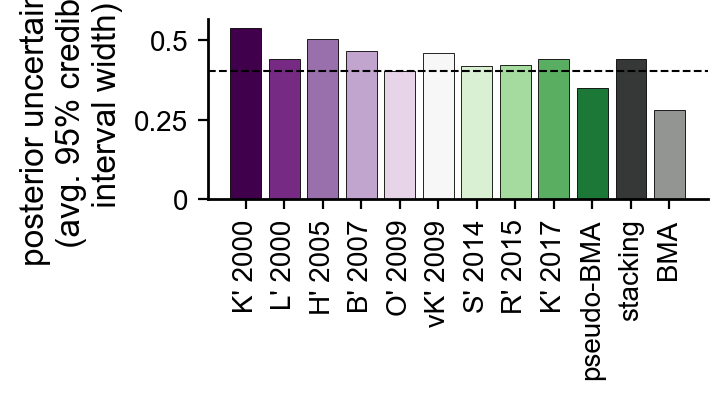

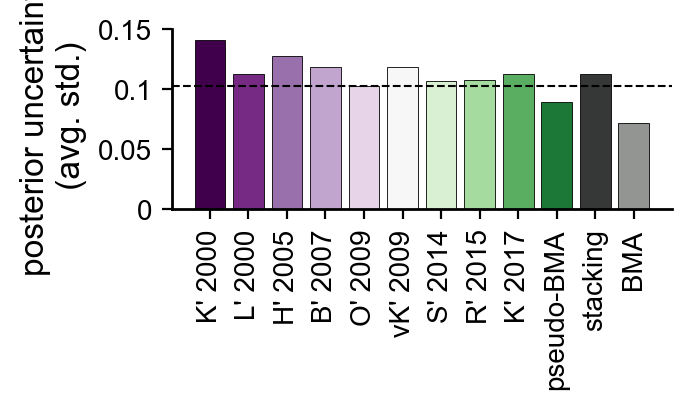

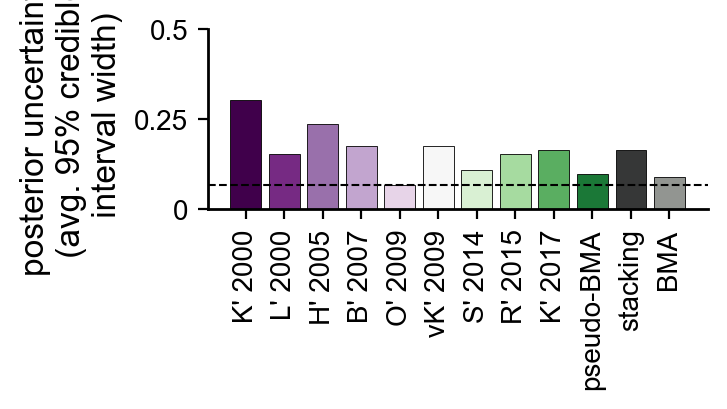

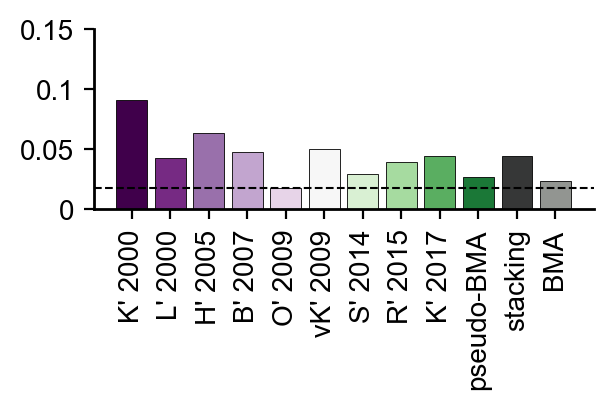

In [19]:
# posterior predictive samples
posterior_uncertainty_95_pred = []
for i, name in enumerate(model_names):
    posterior_uncertainty_95_pred.append(np.nanmean(np.diff(np.nanquantile(posterior_pred_samples[name], [0.025, 0.975], axis=0), axis=0)))

# get index of min uncertainty
min_index_95 = np.argmin(posterior_uncertainty_95_pred)

# add RMSE for BMA and pseudo-BMA
posterior_uncertainty_95_pred.append(np.nanmean(np.diff(np.nanquantile(loo_pbma_combined, [0.025, 0.975], axis=0), axis=0)))
posterior_uncertainty_95_pred.append(np.nanmean(np.diff(np.nanquantile(loo_stack_combined, [0.025, 0.975], axis=0), axis=0)))
posterior_uncertainty_95_pred.append(np.nanmean(np.diff(np.nanquantile(loo_bma_combined, [0.025, 0.975], axis=0), axis=0)))

# make a plot
fig, ax = get_sized_fig_ax(2.5, 0.9)
bar = ax.bar(display_names + ['pseudo-BMA', 'stacking', 'BMA'], posterior_uncertainty_95_pred, edgecolor='k')
for i, br in enumerate(bar):
    br.set_facecolor(colors[i])
xlim = ax.get_xlim()
ax.plot(xlim, [posterior_uncertainty_95_pred[min_index_95]]*2, 'k--', linewidth=0.75)
ax.set_xlim(xlim)
ax.set_xticklabels(display_names + ['pseudo-BMA', 'stacking', 'BMA'], rotation=90, fontsize=10.0)
ax.set_ylabel('posterior uncertainty \n (avg. 95% credible \n interval width)', fontsize=12.0)
ax.set_yticks([0, 0.25, 0.5])
ax.set_yticklabels([0, 0.25, 0.5], fontsize=10.0)

ylim = ax.get_ylim()
# ax.plot([9.5,9.5], ylim, 'k', linewidth=0.75)
ax.set_ylim(ylim)
fig.savefig('../../../results/MAPK/mmi/HF96_post_uncert_95.pdf', transparent=True)

posterior_uncertainty_std = []
for i, name in enumerate(model_names):
    posterior_uncertainty_std.append(np.nanmean(np.nanstd(posterior_pred_samples[name], axis=0)))

# get index of min uncertainty
min_index_std = np.argmin(posterior_uncertainty_std)

# add RMSE for BMA and pseudo-BMA
posterior_uncertainty_std.append(np.nanmean(np.nanstd(loo_pbma_combined, axis=0)))
posterior_uncertainty_std.append(np.nanmean(np.nanstd(loo_stack_combined, axis=0)))
posterior_uncertainty_std.append(np.nanmean(np.nanstd(loo_bma_combined, axis=0)))

# make a plot
fig, ax = get_sized_fig_ax(2.5, 0.9)
bar = ax.bar(display_names + ['pseudo-BMA', 'stacking', 'BMA'], posterior_uncertainty_std, edgecolor='k')
for i, br in enumerate(bar):
    br.set_facecolor(colors[i])
xlim = ax.get_xlim()
ax.plot(xlim, [posterior_uncertainty_std[min_index_std]]*2, 'k--', linewidth=0.75)
ax.set_xlim(xlim)
ax.set_yticks([0, 0.05, 0.1, 0.15])
ax.set_yticklabels([0, 0.05, 0.1, 0.15], fontsize=10.0)
ylim = ax.get_ylim()
# ax.plot([9.5,9.5], ylim, 'k', linewidth=0.75)
ax.set_ylim(ylim)

ax.set_xticklabels(display_names + ['pseudo-BMA', 'stacking', 'BMA'], rotation=90, fontsize=10.0)
ax.set_ylabel('posterior uncertainty \n (avg. std.)', fontsize=12.0)
fig.savefig('../../../results/MAPK/mmi/HF96_post_uncert_std.pdf', transparent=True)

############################################################################################################
# posterior samples
posterior_uncertainty_95 = []
for i, name in enumerate(model_names):
    posterior_uncertainty_95.append(np.nanmean(np.diff(np.nanquantile(posterior_samples[name], [0.025, 0.975], axis=0), axis=0)))

# get index of min uncertainty
min_index_95 = np.argmin(posterior_uncertainty_95)

# add RMSE for BMA and pseudo-BMA
posterior_uncertainty_95.append(np.nanmean(np.diff(np.nanquantile(loo_pbma_combined_post, [0.025, 0.975], axis=0), axis=0)))
posterior_uncertainty_95.append(np.nanmean(np.diff(np.nanquantile(loo_stack_combined_post, [0.025, 0.975], axis=0), axis=0)))
posterior_uncertainty_95.append(np.nanmean(np.diff(np.nanquantile(loo_bma_combined_post, [0.025, 0.975], axis=0), axis=0)))

# make a plot
fig, ax = get_sized_fig_ax(2.5, 0.9)
bar = ax.bar(display_names + ['pseudo-BMA', 'stacking', 'BMA'], posterior_uncertainty_95, edgecolor='k')
for i, br in enumerate(bar):
    br.set_facecolor(colors[i])
xlim = ax.get_xlim()
ax.plot(xlim, [posterior_uncertainty_95[min_index_95]]*2, 'k--', linewidth=0.75)
ax.set_xlim(xlim)
ax.set_xticklabels(display_names + ['pseudo-BMA', 'stacking', 'BMA'], rotation=90, fontsize=10.0)
ax.set_ylabel('posterior uncertainty \n (avg. 95% credible \n interval width)', fontsize=12.0)
ax.set_yticks([0, 0.25, 0.5])
ax.set_yticklabels([0, 0.25, 0.5], fontsize=10.0)

ylim = ax.get_ylim()
# ax.plot([9.5,9.5], ylim, 'k', linewidth=0.75)
ax.set_ylim(ylim)
fig.savefig('../../../results/MAPK/mmi/HF96_post_uncert_95_post_samples.pdf', transparent=True)

posterior_uncertainty_std = []
for i, name in enumerate(model_names):
    posterior_uncertainty_std.append(np.nanmean(np.nanstd(posterior_samples[name], axis=0)))

# get index of min uncertainty
min_index_std = np.argmin(posterior_uncertainty_std)

# add RMSE for BMA and pseudo-BMA
posterior_uncertainty_std.append(np.nanmean(np.nanstd(loo_pbma_combined_post, axis=0)))
posterior_uncertainty_std.append(np.nanmean(np.nanstd(loo_stack_combined_post, axis=0)))
posterior_uncertainty_std.append(np.nanmean(np.nanstd(loo_bma_combined_post, axis=0)))

# make a plot
fig, ax = get_sized_fig_ax(2.5, 0.9)
bar = ax.bar(display_names + ['pseudo-BMA', 'stacking', 'BMA'], posterior_uncertainty_std, edgecolor='k')
for i, br in enumerate(bar):
    br.set_facecolor(colors[i])
xlim = ax.get_xlim()
ax.plot(xlim, [posterior_uncertainty_std[min_index_std]]*2, 'k--', linewidth=0.75)
ax.set_xlim(xlim)
ax.set_yticks([0, 0.05, 0.1, 0.15])
ax.set_yticklabels([0, 0.05, 0.1, 0.15], fontsize=10.0)

ylim = ax.get_ylim()
# ax.plot([9.5,9.5], ylim, 'k', linewidth=0.75)
ax.set_ylim(ylim)
ax.set_xticklabels(display_names + ['pseudo-BMA', 'stacking', 'BMA'], rotation=90, fontsize=10.0)
# ax.set_ylabel('posterior uncertainty \n (avg. std.)', fontsize=12.0)
fig.savefig('../../../results/MAPK/mmi/HF96_post_uncert_std_post_samples.pdf', transparent=True)

In [20]:
stats = {
    'RMSE':{
        'post_pred':RMSE_samples_pred,
        'post':RMSE_samples,
    },
    'credible_95':{
        'post_pred':posterior_uncertainty_95_pred,
        'post':posterior_uncertainty_95,
    },
    'std':{
        'post_pred':posterior_uncertainty_std,
        'post':posterior_uncertainty_std,
    },
}

with open('../../../results/MAPK/mmi/HF96_all_models_MMI_stats.json', 'w') as file:
    file.write(json.dumps(stats))

### Make MMI predictions of dynamcis

In [21]:
# load posterior predictions of dynamics
savedir = '../../../results/MAPK/param_est/HF96_synthetic_data/'

trajs = {}

for model in model_names:
    trajs[model] = np.load(savedir+model+'/traj_predict.npy')

# for some reason some of the vonKriegsheim_2009 trajectories have inf at the final time, so we set those values to nan
trajs['vonKriegsheim_2009'][np.isinf(trajs['vonKriegsheim_2009'])] = np.nan

# load trajectory data
inputs_traj, data_traj, data_std_traj, times_traj = load_data_json('../../../results/MAPK/HF_96_traj_data.json', data_std=True, time=True)
data_time_to_mins = 60

Now perform weighted averaging of the posterior predictive samples from each model

In [22]:
loo_pbma_combined_traj = np.zeros_like(trajs['kholodenko_2000'])
loo_stack_combined_traj = np.zeros_like(trajs['kholodenko_2000'])
loo_bma_combined_traj = np.zeros_like(trajs['kholodenko_2000'])
for i, name in enumerate(trajs.keys()):
    loo_pbma_combined_traj += compare_data_loo_pbma.loc[name]['weight']*trajs[name]
    loo_stack_combined_traj += compare_data_loo_stack.loc[name]['weight']*trajs[name]
    loo_bma_combined_traj += model_probs[i]*trajs[name]

trajs_mmi = {'loo_pbma_combined_traj':loo_pbma_combined_traj,
         'loo_stack_combined_traj':loo_stack_combined_traj,
         'loo_bma_combined_traj':loo_bma_combined_traj}

# times = np.linspace(0.0, 240.0, loo_bma_combined_traj.shape[2])

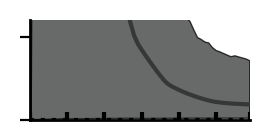

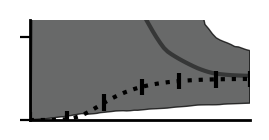

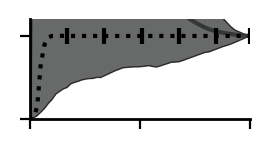

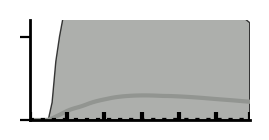

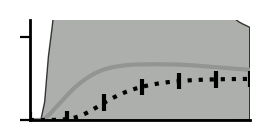

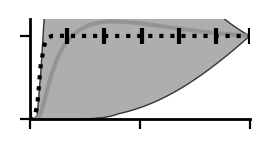

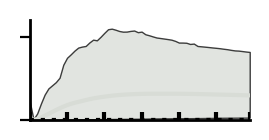

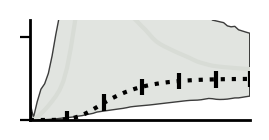

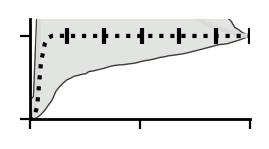

In [23]:
# make plots
fig_savedir = '../../../results/MAPK/mmi/'
cols = [colors[-3], colors[-2], colors[-1]]
for idx, name in enumerate(trajs_mmi.keys()):
    plot_posterior_trajectories(trajs_mmi[name], data_traj, data_std_traj, times_traj, cols[idx], 
                                            inputs_traj, fig_savedir,
                                            name, data_time_to_mins=60,
                                            width=1.1, height=0.5, 
                                            data_downsample=10,
                                            ylim=[[0.0, 1.2], [0.0, 1.2], [0.0, 1.2]],
                                            y_ticks=[[0.0, 1.0], [0.0, 1.0], [0.0, 1.0]],
                                            fname=name+'_pred_traj_', labels=False)

#### Compute posterior RMSE and Uncertainty

In [24]:
RMSE = {}
credible_95 = {}
for name in model_names:
    RMSE[name] = list(np.sqrt(np.nanmean((np.nanmean(trajs[name], axis=0) - data_traj)**2, axis=1)))
    credible_95[name] = list(np.nanmean(np.squeeze(np.diff(np.nanquantile(trajs[name], [0.025, 0.975], axis=0),axis=0)), axis=1))

# add MMI stats
for name in trajs_mmi.keys():
    RMSE[name] = list(np.sqrt(np.nanmean((np.nanmean(trajs_mmi[name], axis=0) - data_traj)**2, axis=1)))
    credible_95[name] = list(np.nanmean(np.squeeze(np.diff(np.nanquantile(trajs_mmi[name], [0.025, 0.975], axis=0),axis=0)), axis=1))

stats = {
    'RMSE':RMSE,
    'credible_95':credible_95,
}

with open('../../../results/MAPK/mmi/HF96_synth_DR_pred_traj_stats.json', 'w') as file:
    file.write(json.dumps(stats))